In [1]:
import os
# 获取当前工作目录
current_path = os.getcwd()
print(current_path)

C:\Users\11945\统计分析与建模\code


In [2]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# 设置matplotlib中文支持
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号

# 加载数据
df = pd.read_csv('预报预警数据_灾害性天气预警_2920000900329 - 1年.csv')

# 查看数据前几行
print("数据前5行：")
print(df.head())
print("\n数据形状：", df.shape)
print("\n列名：", df.columns.tolist())

数据前5行：
  信号级别  AUTOSENTCOUNT                                               发布内容  \
0   蓝色              0  全市陆地,森林火险,橙色,2025-12-19 09:00:00;.【深圳市解除分区强季风蓝...   
1   蓝色              0  【深圳市分区强季风蓝色预警信号】深圳市气象台2025年12月25日07时50分发布盐田区、大...   
2   红色              0  全市陆地,森林火险,橙色,2025-12-19 09:00:00;.【深圳市森林火险红色预警...   
3   橙色              0  【深圳市森林火险红色预警信号降级为橙色】深圳市森林防灭火指挥和深圳市气象台2025年12月1...   
4   蓝色              0  全市陆地,森林火险,红色,2025-11-26 11:00:00;.【深圳市解除分区强季风蓝...   

                    入库时间  自动检测消息发布状态  信号编号                同步编号 信号发布签发人  \
0  \t2025-12-25 19:59:17           0   138  AAA30mABCAACLdcAAK       -   
1  \t2025-12-25 07:52:14           0   138  AAA30mAAcAACpE8AAP       -   
2  \t2025-12-19 09:00:40           0   136  AAA30mAAcAACpE+AAI       -   
3  \t2025-12-19 09:00:40           0   137  AAA30mAAcAACpE+AAH       -   
4  \t2025-11-27 22:31:22           0   137  AAA30mABCAACLd3AAL       -   

     记录编号                   发布时间 发布状态(发布/取消)  AUTOSENTFLAG  \
0  105329  \t2025-12-25 20:00

In [3]:
# 数据基本信息
print("\n数据基本信息：")
print(df.info())

# 检查缺失值
print("\n缺失值统计：")
print(df.isnull().sum())

# 描述性统计
print("\n描述性统计：")
print(df.describe(include='all'))


数据基本信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892 entries, 0 to 891
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   信号级别           892 non-null    object
 1   AUTOSENTCOUNT  892 non-null    int64 
 2   发布内容           892 non-null    object
 3   入库时间           892 non-null    object
 4   自动检测消息发布状态     892 non-null    int64 
 5   信号编号           892 non-null    int64 
 6   同步编号           892 non-null    object
 7   信号发布签发人        892 non-null    object
 8   记录编号           892 non-null    int64 
 9   发布时间           892 non-null    object
 10  发布状态(发布/取消)    892 non-null    object
 11  AUTOSENTFLAG   892 non-null    int64 
 12  信号影响区域         892 non-null    object
 13  信号类型           892 non-null    object
 14  记录序号           892 non-null    int64 
 15  自动检测循环次数       892 non-null    int64 
dtypes: int64(7), object(9)
memory usage: 111.6+ KB
None

缺失值统计：
信号级别             0
AUTOSENTCOUNT    0
发布内容     

In [4]:
# 清理空格和特殊字符
for col in ['发布时间', '入库时间']:
    df[col] = df[col].str.strip().str.replace('\t', '')

# 转换时间列为datetime类型
df['发布时间'] = pd.to_datetime(df['发布时间'])
df['入库时间'] = pd.to_datetime(df['入库时间'])

# 处理信号影响区域
def clean_region(region):
    if pd.isna(region) or region == '-':
        return '未知区域'
    # 移除可能的特殊字符
    region = str(region).replace('、', ',').replace('；', ',').replace(' ', '')
    return region

df['clean_region'] = df['信号影响区域'].apply(clean_region)

# 提取预警类型和状态
df['是否发布'] = df['发布状态(发布/取消)'].apply(lambda x: 1 if x == '发布' else 0)

# 查看清洗后的数据
print("\n清洗后数据样例：")
print(df[['发布时间', '信号类型', '信号级别', 'clean_region', '是否发布']].head())


清洗后数据样例：
                 发布时间  信号类型 信号级别              clean_region  是否发布
0 2025-12-25 20:00:00   强季风   蓝色  盐田区,大鹏新区,珠江口,深圳湾,大鹏湾,大亚湾     0
1 2025-12-25 07:50:00   强季风   蓝色  盐田区,大鹏新区,珠江口,深圳湾,大鹏湾,大亚湾     1
2 2025-12-19 09:00:00  森林火险   红色                      全市陆地     0
3 2025-12-19 09:00:00  森林火险   橙色                      全市陆地     1
4 2025-11-27 22:30:00   强季风   蓝色          盐田区,大鹏新区,大鹏湾,大亚湾     0


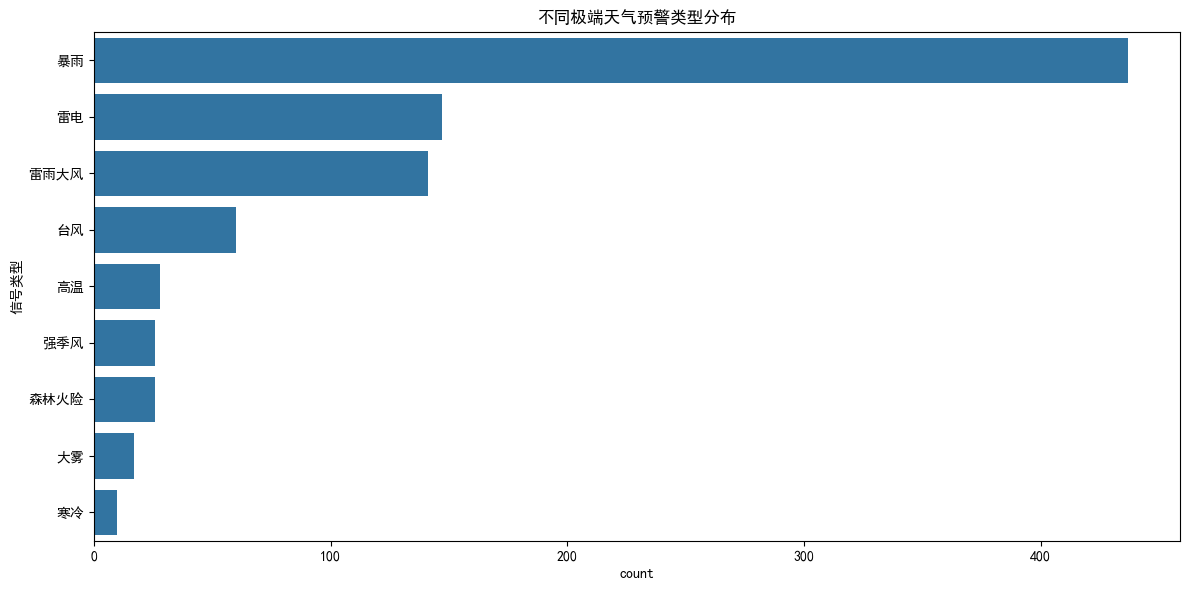

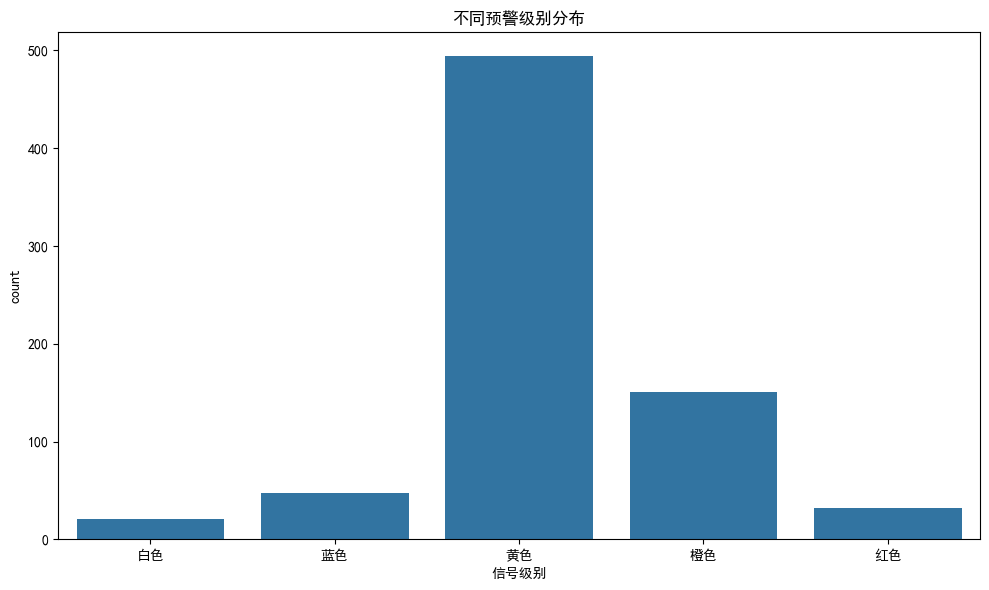

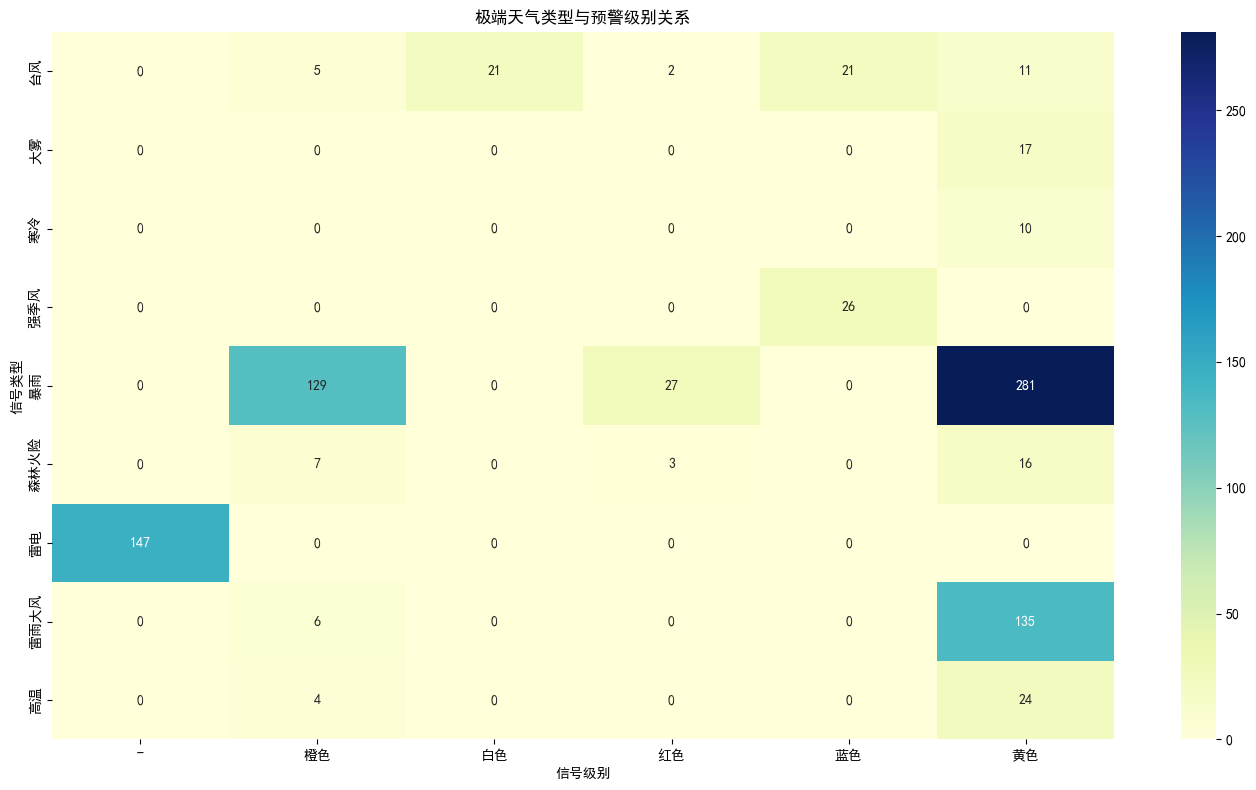

In [5]:
# 极端天气类型分布
plt.figure(figsize=(12, 6))
sns.countplot(y='信号类型', data=df, order=df['信号类型'].value_counts().index)
plt.title('不同极端天气预警类型分布')
plt.tight_layout()
plt.savefig('weather_type_distribution.png')

# 预警级别分布
plt.figure(figsize=(10, 6))
sns.countplot(x='信号级别', data=df, order=['白色', '蓝色', '黄色', '橙色', '红色'])
plt.title('不同预警级别分布')
plt.tight_layout()
plt.savefig('warning_level_distribution.png')

# 类型和级别的交叉分析
plt.figure(figsize=(14, 8))
type_level = pd.crosstab(df['信号类型'], df['信号级别'])
sns.heatmap(type_level, annot=True, fmt='d', cmap='YlGnBu')
plt.title('极端天气类型与预警级别关系')
plt.tight_layout()
plt.savefig('type_level_heatmap.png')

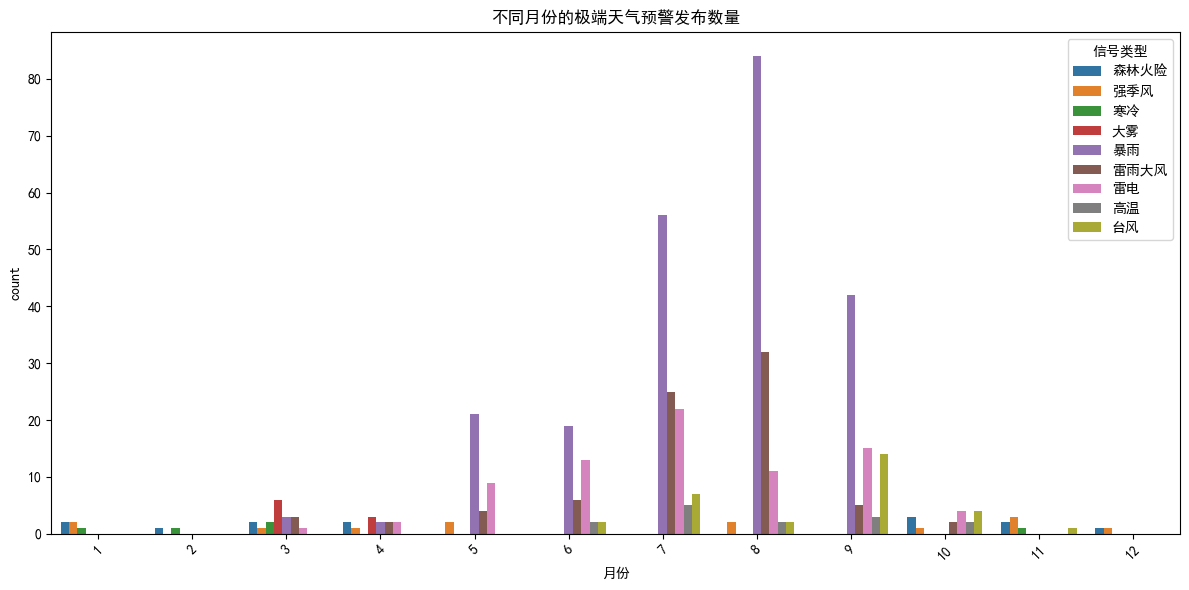

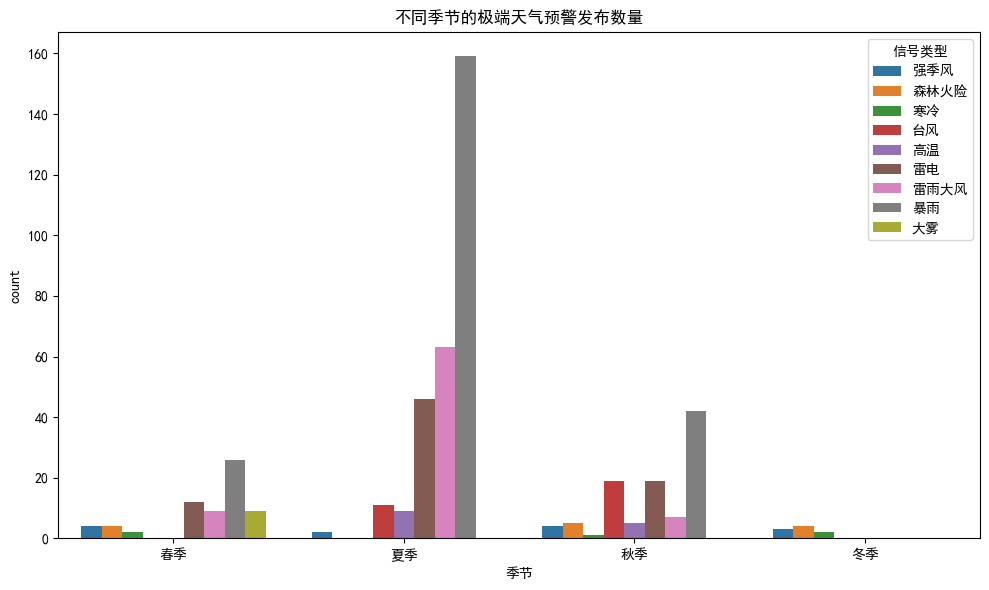

In [6]:
# 提取时间特征
df['月份'] = df['发布时间'].dt.month
df['季节'] = df['月份'].apply(lambda x: '春季' if x in [3,4,5] else ('夏季' if x in [6,7,8] else ('秋季' if x in [9,10,11] else '冬季')))
df['小时'] = df['发布时间'].dt.hour
df['星期几'] = df['发布时间'].dt.dayofweek  # 0=周一, 6=周日

# 按月份分析
plt.figure(figsize=(12, 6))
sns.countplot(x='月份', hue='信号类型', data=df[df['是否发布'] == 1])
plt.title('不同月份的极端天气预警发布数量')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('monthly_warnings.png')

# 按季节分析
plt.figure(figsize=(10, 6))
season_order = ['春季', '夏季', '秋季', '冬季']
sns.countplot(x='季节', hue='信号类型', data=df[df['是否发布'] == 1], order=season_order)
plt.title('不同季节的极端天气预警发布数量')
plt.tight_layout()
plt.savefig('seasonal_warnings.png')

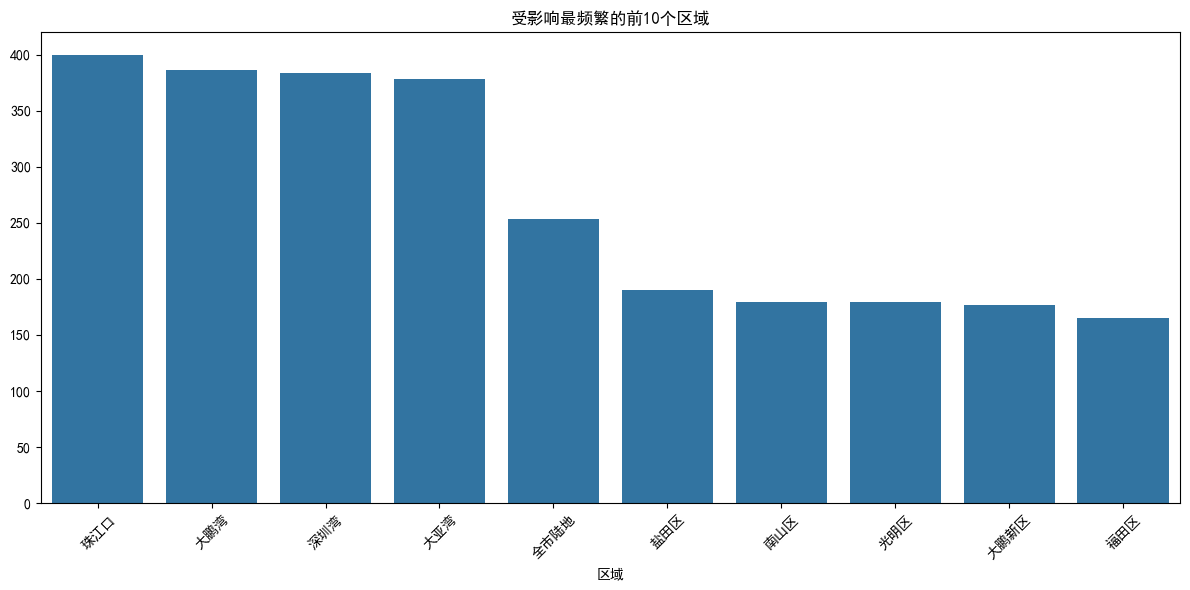

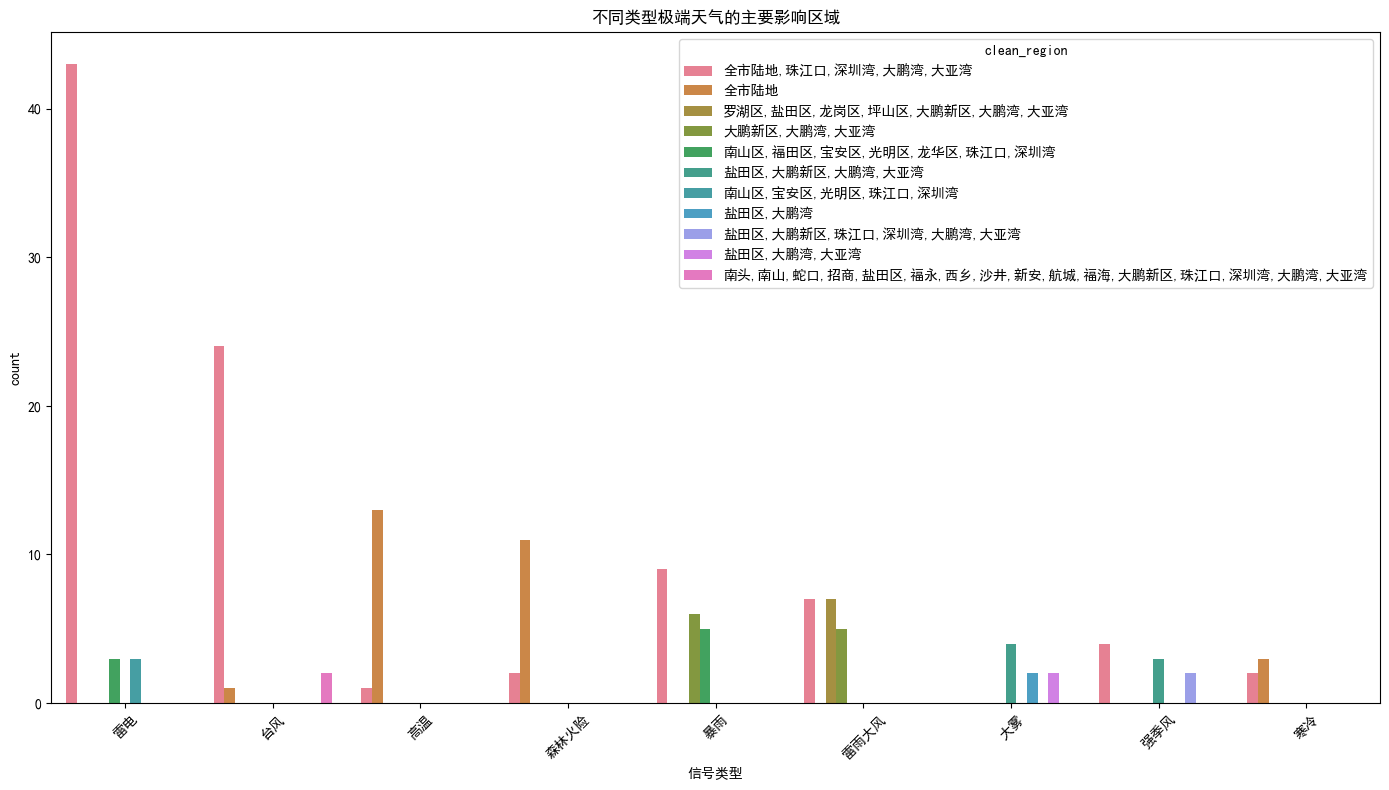

In [7]:
# 区域分布（前10个最常受影响的区域）
all_regions = []
for regions in df['clean_region']:
    for region in str(regions).split(','):
        all_regions.append(region.strip())

region_df = pd.DataFrame(all_regions, columns=['区域'])
top_regions = region_df['区域'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_regions.index, y=top_regions.values)
plt.title('受影响最频繁的前10个区域')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('top_affected_regions.png')

# 不同类型天气的主要影响区域
plt.figure(figsize=(14, 8))
type_regions = df[df['是否发布'] == 1].groupby(['信号类型', 'clean_region']).size().reset_index(name='count')
top_type_regions = type_regions.sort_values('count', ascending=False).groupby('信号类型').head(3)
sns.barplot(x='信号类型', y='count', hue='clean_region', data=top_type_regions)
plt.title('不同类型极端天气的主要影响区域')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('type_region_analysis.png')

In [8]:
# 构建预警持续时间数据
# 创建一个字典来跟踪每个预警的发布和取消
warning_events = {}

# 按时间排序数据
sorted_df = df.sort_values('发布时间')

# 遍历每条记录
for idx, row in sorted_df.iterrows():
    # 创建唯一标识符，使用信号类型、级别、影响区域和日期
    date_str = row['发布时间'].strftime('%Y%m%d')
    warning_id = f"{row['信号类型']}_{row['信号级别']}_{row['clean_region']}_{date_str}"
    
    # 检查是否已有相同预警ID
    if row['发布状态(发布/取消)'] == '发布':
        if warning_id not in warning_events:
            warning_events[warning_id] = {
                'start_time': row['发布时间'],
                'signal_type': row['信号类型'],
                'signal_level': row['信号级别'],
                'region': row['clean_region'],
                'end_time': None
            }
    elif row['发布状态(发布/取消)'] == '取消':
        if warning_id in warning_events and warning_events[warning_id]['end_time'] is None:
            warning_events[warning_id]['end_time'] = row['发布时间']

# 构建持续时间数据
duration_data = []
for warning_id, event in warning_events.items():
    if event['end_time'] is not None:
        duration_hours = (event['end_time'] - event['start_time']).total_seconds() / 3600
        
        # 只保留合理的持续时间 (大于0小时，小于30天)
        if 0 < duration_hours < 720:
            duration_data.append({
                '信号类型': event['signal_type'],
                '信号级别': event['signal_level'],
                '影响区域': event['region'],
                '开始时间': event['start_time'],
                '结束时间': event['end_time'],
                '持续时间(小时)': duration_hours,
                '月份': event['start_time'].month,
                '季节': '春季' if event['start_time'].month in [3,4,5] else (
                        '夏季' if event['start_time'].month in [6,7,8] else (
                        '秋季' if event['start_time'].month in [9,10,11] else '冬季'))
            })

# 创建DataFrame
duration_df = pd.DataFrame(duration_data)

# 检查数据
print("持续时间数据样本:")
print(duration_df.head())
print("\n数据形状:", duration_df.shape)
print("\n列名:", duration_df.columns.tolist())

# 保存数据
duration_df.to_csv('warning_duration.csv', index=False)

持续时间数据样本:
  信号类型 信号级别                  影响区域                开始时间                结束时间  \
0  强季风   蓝色  罗湖区,盐田区,大鹏新区,大鹏湾,大亚湾 2025-01-10 06:36:00 2025-01-10 10:17:00   
1   大雾   黄色               盐田区,大鹏湾 2025-03-04 01:55:00 2025-03-04 07:48:00   
2   雷电    -  全市陆地,珠江口,深圳湾,大鹏湾,大亚湾 2025-03-04 13:55:00 2025-03-04 15:40:00   
3   大雾   黄色      盐田区,大鹏新区,大鹏湾,大亚湾 2025-03-14 00:55:00 2025-03-14 07:40:00   
4   大雾   黄色      盐田区,大鹏新区,大鹏湾,大亚湾 2025-03-15 03:15:00 2025-03-15 09:56:00   

   持续时间(小时)  月份  季节  
0  3.683333   1  冬季  
1  5.883333   3  春季  
2  1.750000   3  春季  
3  6.750000   3  春季  
4  6.683333   3  春季  

数据形状: (171, 8)

列名: ['信号类型', '信号级别', '影响区域', '开始时间', '结束时间', '持续时间(小时)', '月份', '季节']


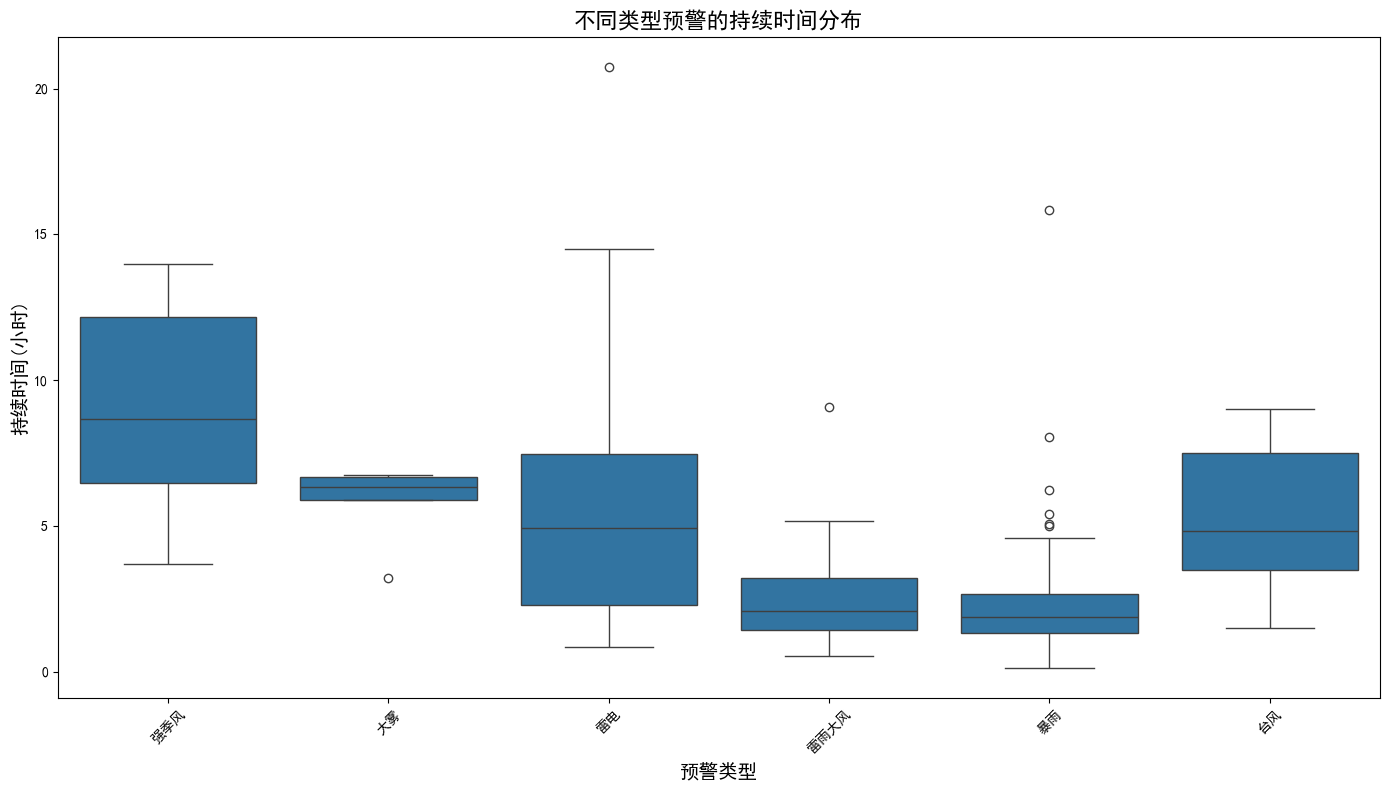

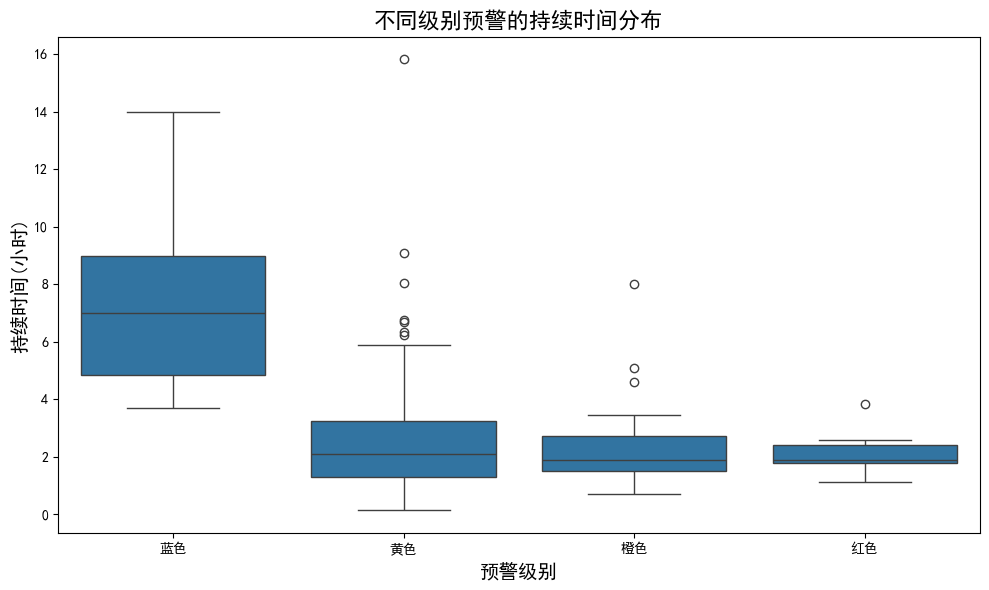

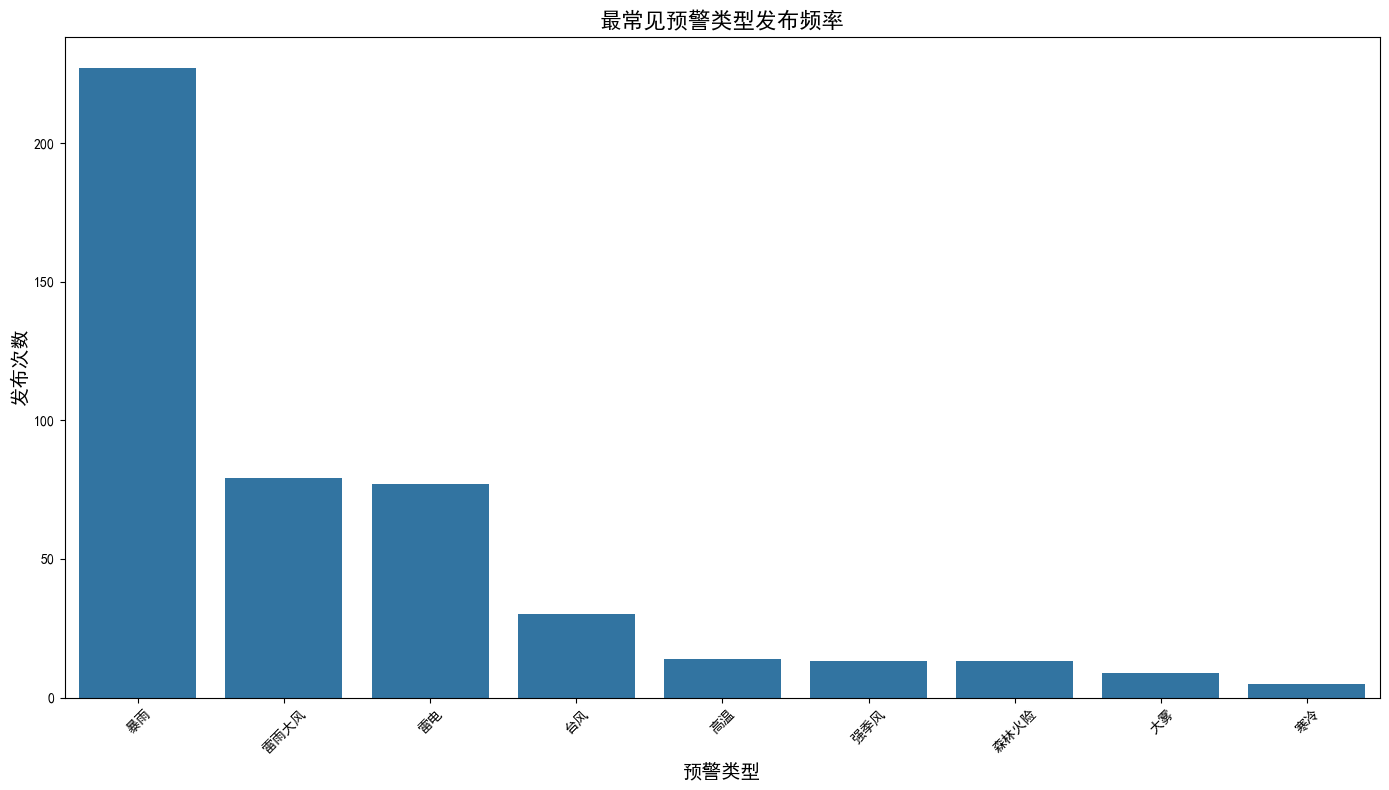

In [9]:
# 检查是否有足够数据进行可视化
if not duration_df.empty and len(duration_df) > 5:
    # 可视化不同类型预警的持续时间
    plt.figure(figsize=(14, 8))
    
    # 只显示最常见的8种预警类型
    top_types = duration_df['信号类型'].value_counts().head(8).index
    filtered_df = duration_df[duration_df['信号类型'].isin(top_types)]
    
    sns.boxplot(x='信号类型', y='持续时间(小时)', data=filtered_df)
    plt.title('不同类型预警的持续时间分布', fontsize=16)
    plt.xlabel('预警类型', fontsize=14)
    plt.ylabel('持续时间(小时)', fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('duration_by_type.png')
    
    # 按预警级别分析持续时间
    plt.figure(figsize=(10, 6))
    level_order = ['白色', '蓝色', '黄色', '橙色', '红色']
    valid_levels = [level for level in level_order if level in duration_df['信号级别'].unique()]
    
    sns.boxplot(x='信号级别', y='持续时间(小时)', 
                data=duration_df[duration_df['信号级别'].isin(valid_levels)], 
                order=valid_levels)
    plt.title('不同级别预警的持续时间分布', fontsize=16)
    plt.xlabel('预警级别', fontsize=14)
    plt.ylabel('持续时间(小时)', fontsize=14)
    plt.tight_layout()
    plt.savefig('duration_by_level.png')

# 显示预警类型的频率分布
plt.figure(figsize=(14, 8))
type_counts = df[df['是否发布'] == 1]['信号类型'].value_counts().head(10)
sns.barplot(x=type_counts.index, y=type_counts.values)
plt.title('最常见预警类型发布频率', fontsize=16)
plt.xlabel('预警类型', fontsize=14)
plt.ylabel('发布次数', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('warning_type_frequency.png')


分类模型数据形状: (467, 24)
特征列表: ['信号级别', 'AUTOSENTCOUNT', '发布内容', '入库时间', '自动检测消息发布状态', '信号编号', '同步编号', '信号发布签发人', '记录编号', '发布时间', '发布状态(发布/取消)', 'AUTOSENTFLAG', '信号影响区域', '信号类型', '记录序号', '自动检测循环次数', 'clean_region', '是否发布', '月份', '季节', '小时', '星期几', '是否工作日', '过去30天同类型预警次数']

分类模型评估:
准确率: 0.8255813953488372

分类报告:
              precision    recall  f1-score   support

          台风       1.00      0.67      0.80         6
          暴雨       0.91      0.89      0.90        46
          雷电       0.71      0.67      0.69        15
        雷雨大风       0.68      0.81      0.74        16
          高温       0.75      1.00      0.86         3

    accuracy                           0.83        86
   macro avg       0.81      0.81      0.80        86
weighted avg       0.84      0.83      0.83        86


特征重要性:
             特征       重要性
3  过去30天同类型预警次数  0.539025
1            小时  0.215013
0            月份  0.207271
2         是否工作日  0.038691

分类模型已成功保存为 'warning_type_classifier.pkl'


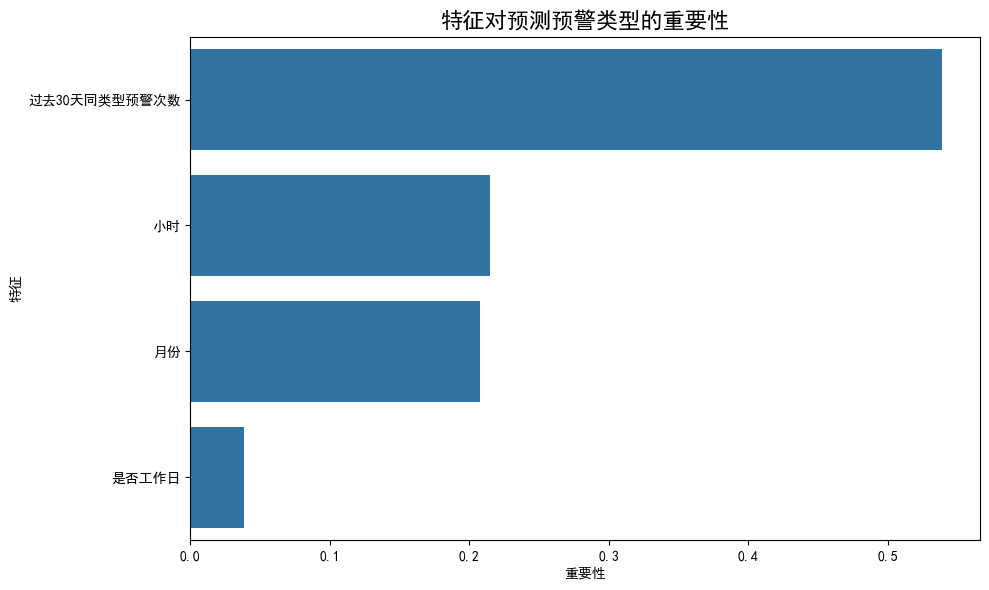

In [ ]:
# 重新准备分类模型数据
classification_df = df[df['是否发布'] == 1].copy()

# 确保有足够数据
if len(classification_df) > 10:
    # 特征工程：添加时序特征
    classification_df['月份'] = classification_df['发布时间'].dt.month
    classification_df['小时'] = classification_df['发布时间'].dt.hour
    classification_df['星期几'] = classification_df['发布时间'].dt.dayofweek
    classification_df['是否工作日'] = classification_df['星期几'].apply(lambda x: 1 if x < 5 else 0)
    
    # 计算历史特征：过去30天内同类型的预警次数
    classification_df = classification_df.sort_values('发布时间')
    classification_df['过去30天同类型预警次数'] = 0
    
    for idx, row in classification_df.iterrows():
        past_date = row['发布时间'] - pd.Timedelta(days=30)
        count = classification_df[
            (classification_df['发布时间'] >= past_date) & 
            (classification_df['发布时间'] < row['发布时间']) &
            (classification_df['信号类型'] == row['信号类型'])
        ].shape[0]
        classification_df.at[idx, '过去30天同类型预警次数'] = count
    
    # 保存处理后的数据
    classification_df.to_csv('processed_weather_data.csv', index=False)
    
    print("\n分类模型数据形状:", classification_df.shape)
    print("特征列表:", classification_df.columns.tolist())

# 确保有足够数据再进行建模
if len(classification_df) > 20:
    # 选择最频繁的5种预警类型
    top_types = classification_df['信号类型'].value_counts().head(5).index
    filtered_df = classification_df[classification_df['信号类型'].isin(top_types)]
    
    if len(filtered_df) > 20:
        # 特征和目标
        X = filtered_df[['月份', '小时', '是否工作日', '过去30天同类型预警次数']]
        y = filtered_df['信号类型']
        
        # 分割数据
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        # 训练模型
        rf_classifier = RandomForestClassifier(n_estimators=50, random_state=42)
        rf_classifier.fit(X_train, y_train)
        
        # 评估
        y_pred = rf_classifier.predict(X_test)

        # 绘制 AUROC 曲线
        from sklearn.preprocessing import label_binarize
        from sklearn.metrics import roc_curve, auc
        from itertools import cycle

        # 获取类别数量
        classes = np.unique(y)
        n_classes = len(classes)

        # 将标签二值化（one-hot）
        y_test_bin = label_binarize(y_test, classes=classes)
        
        # 获取预测概率
        y_score = rf_classifier.predict_proba(X_test)  # shape: (n_samples, n_classes)

        # 计算每个类别的 ROC 曲线和 AUC
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # 计算 micro-average ROC 曲线和 AUC
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        # 计算 macro-average ROC 曲线（可选）
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= n_classes
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        # 绘图
        plt.figure(figsize=(10, 8))
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                     label=f'ROC curve of {classes[i]} (AUC = {roc_auc[i]:.2f})')

        plt.plot(fpr["micro"], tpr["micro"],
                 label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})',
                 color='deeppink', linestyle=':', linewidth=3)

        plt.plot(fpr["macro"], tpr["macro"],
                 label=f'Macro-average ROC curve (AUC = {roc_auc["macro"]:.2f})',
                 color='navy', linestyle='--', linewidth=3)

        plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance level (AUC = 0.5)')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curves for Multi-class')
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.savefig('roc_curve_multiclass.png')
        plt.show()

        print(f"\nMicro-average AUC: {roc_auc['micro']:.4f}")
        print(f"Macro-average AUC: {roc_auc['macro']:.4f}")


        print("\n分类模型评估:")
        print("准确率:", accuracy_score(y_test, y_pred))
        print("\n分类报告:")
        print(classification_report(y_test, y_pred))
        
        # 特征重要性
        feature_importances = pd.DataFrame({
            '特征': X.columns,
            '重要性': rf_classifier.feature_importances_
        }).sort_values('重要性', ascending=False)
        
        print("\n特征重要性:")
        print(feature_importances)
        
        # 可视化特征重要性
        plt.figure(figsize=(10, 6))
        sns.barplot(x='重要性', y='特征', data=feature_importances)
        plt.title('特征对预测预警类型的重要性', fontsize=16)
        plt.tight_layout()
        plt.savefig('feature_importance_classification.png')

        import joblib
        joblib.dump(rf_classifier, 'warning_type_classifier.pkl')
        print("\n分类模型已成功保存为 'warning_type_classifier.pkl'")

In [11]:
# 确保有足够数据
if len(duration_df) > 20:
    # 准备回归数据
    regression_df = duration_df.copy()
    
    # 预警级别编码
    level_mapping = {'白色': 1, '蓝色': 2, '黄色': 3, '橙色': 4, '红色': 5}
    regression_df['预警级别编码'] = regression_df['信号级别'].map(level_mapping)
    
    # 移除缺少级别编码的记录
    regression_df = regression_df.dropna(subset=['预警级别编码'])
    
    if len(regression_df) > 20:
        # 特征和目标
        X_reg = regression_df[['月份', '预警级别编码']]
        y_reg = regression_df['持续时间(小时)']
        
        # 去除异常值（大于99%分位数的值）
        upper_limit = y_reg.quantile(0.99)
        valid_mask = y_reg <= upper_limit
        X_reg = X_reg[valid_mask]
        y_reg = y_reg[valid_mask]
        
        # 分割数据
        X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
            X_reg, y_reg, test_size=0.2, random_state=42
        )
        
        # 训练模型
        rf_regressor = RandomForestRegressor(n_estimators=50, random_state=42)
        rf_regressor.fit(X_train_reg, y_train_reg)
        
        # 评估
        y_pred_reg = rf_regressor.predict(X_test_reg)
        print("\n回归模型评估:")
        print("MSE:", mean_squared_error(y_test_reg, y_pred_reg))
        print("R²:", r2_score(y_test_reg, y_pred_reg))


回归模型评估:
MSE: 2.401037353842972
R²: 0.24854516571507768
